## Lihua Dong (ld457)
## Kaifeng Gu (kg484)
## Duo Sun (ds2324)

### This Jupyter notebook must be run on Python 2 because the CLA algorithm is writtern on Python 2

In [1]:
import pandas as pd
import numpy as np
import datetime
from collections import defaultdict
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Compute one covariance matrix every month, looking back three months at each calculation

For 10 ETF, We choose the most typical sector ETFs:

Financial Select Sector SPDR (NYSE:XLF), 
Consumer Discretionary Select Sector SPDR Fund (NYSE:XLY), 
Technology Select Sector SPDR Fund (NYSE:XLK), 
Materials Select Sector SPDR Fund (NYSE:XLB), 
Industrial Select Sector SPDR Fund (NYSE:XLI), 
Energy Select Sector SPDR Fund (NYSE:XLE), 
Utilities Select Sector SPDR Fund (NYSE:XLU), 
Health Care Select Sector SPDR Fund (NYSE:XLV), 
Consumer Staples Select Sector SPDR Fund (NYSE:XLP), 
SPDR S&P 500 ETF (NYSE:SPY).

We then extract data from Tiingo API, from 2010-01-01 to 2018-06-29.

In [2]:
data = pd.read_csv('5256_project_data.csv')
data = data.set_index('date')
data.index = list(map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'), data.index))
data_ret = data.pct_change(1).dropna()

In [3]:
# starting year
start_year = 2010
data_ret = data_ret.loc[data_ret.index >= datetime.datetime(start_year, 1, 1)]
months = []
for y in range(start_year, 2019):
    for m in range(1,13):
        months.append(datetime.datetime(y, m, 1))
months = months[:-5]

lookback = defaultdict(dict)
lookback_dates = months[3:]

for i in range(len(lookback_dates)):
    # Lookback 3-month returns
    lookback[months[i+3]]['ret'] = data_ret[(data_ret.index >= months[i]) & (data_ret.index < months[i+3])]
    
    # Lookback 3-month covariance matrix
    lookback[months[i+3]]['cov'] = lookback[months[i+3]]['ret'].cov()
    
    # Lookback 3-month correlation matrix
    lookback[months[i+3]]['corr'] = lookback[months[i+3]]['ret'].corr()

## Compute the monthly allocations using CLA, IVP and HRP

In [4]:
import CLA as CLA
from HRP import correlDist,getIVP,getQuasiDiag,getRecBipart

def getHRP(cov,corr):
    # Construct a hierarchical portfolio
    corr,cov=pd.DataFrame(corr),pd.DataFrame(cov)
    dist=correlDist(corr)
    link=sch.linkage(dist,'single')
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels
    hrp=getRecBipart(cov,sortIx)
    return hrp.sort_index()

In [5]:
%%time
cla_allo = pd.DataFrame(index=lookback_dates, columns=data.columns)
ivp_allo = pd.DataFrame(index=lookback_dates, columns=data.columns)
hrp_allo = pd.DataFrame(index=lookback_dates, columns=data.columns)
for month in lookback_dates:
    r = lookback[month]['ret']
    cov = lookback[month]['cov'].values
    corr = lookback[month]['corr'].values

    # CLA allocation
    mean=r.mean().values.reshape(-1,1)
    lB=np.zeros(mean.shape)
    uB=np.ones(mean.shape)
    cla=CLA.CLA(mean,cov,lB,uB)
    cla.solve()

    # Get Minimum Variance portfolio
    mv, w_cla = cla.getMinVar()
    
    # IVP allocation
    w_ivp = getIVP(cov=cov)
    
    # HRP allocation
    w_hrp = getHRP(cov=cov, corr=corr)
    
    cla_allo.loc[month, :] = w_cla.reshape(-1)
    ivp_allo.loc[month, :] = w_ivp
    hrp_allo.loc[month, :] = w_hrp.values


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


CPU times: user 10.9 s, sys: 946 ms, total: 11.8 s
Wall time: 6.53 s


In [6]:
cla_allo.head()

,XLK,XLF,XLE,XLU,XLB,XLP,XLY,XLI,XLV,SPY
2010-04-01,0,0,0,0,0,1,0,0,0,0
2010-05-01,0.0131513,0,0,0,0,0.986849,0,0,0,0
2010-06-01,0,0,0,0,0,0.863652,0,0,0.136348,0
2010-07-01,0,0,0,0,0,0.656055,0,0,0.343945,0
2010-08-01,0,0,0,0,0,0.550822,0,0,0.449178,0


In [7]:
hrp_allo.head()

,XLK,XLF,XLE,XLU,XLB,XLP,XLY,XLI,XLV,SPY
2010-04-01,0.100985,0.070159,0.0338849,0.168646,0.0478365,0.278815,0.121594,0.0445275,0.0726188,0.0609332
2010-05-01,0.130124,0.0551417,0.0640939,0.156412,0.0407031,0.19428,0.101825,0.0417522,0.154634,0.0610341
2010-06-01,0.0972173,0.0257949,0.0326525,0.168455,0.0315011,0.247577,0.0376696,0.0695148,0.194101,0.0955162
2010-07-01,0.05317,0.0265888,0.0320063,0.15217,0.0318864,0.245277,0.0753134,0.0679036,0.218927,0.0967571
2010-08-01,0.103698,0.0609825,0.0335989,0.162749,0.0319335,0.236532,0.0765071,0.0352273,0.204893,0.0538779


In [8]:
ivp_allo.head()

,XLK,XLF,XLE,XLU,XLB,XLP,XLY,XLI,XLV,SPY
2010-04-01,0.0807941,0.0503361,0.049737,0.120996,0.0382719,0.250765,0.113665,0.0797334,0.106592,0.10911
2010-05-01,0.123062,0.0457202,0.0469529,0.122475,0.0468189,0.223471,0.0844275,0.0755493,0.121084,0.110439
2010-06-01,0.0883137,0.0444576,0.0598274,0.154233,0.0577177,0.210298,0.0649237,0.0631483,0.164874,0.0922064
2010-07-01,0.0903653,0.0487392,0.0543964,0.141084,0.05845,0.20477,0.0669095,0.0603266,0.182771,0.0921879
2010-08-01,0.0888281,0.0522377,0.059653,0.135011,0.0566962,0.196218,0.0675661,0.060779,0.190053,0.0929577


## Plot the time of allocations

Text(0,0.5,'Allocations')

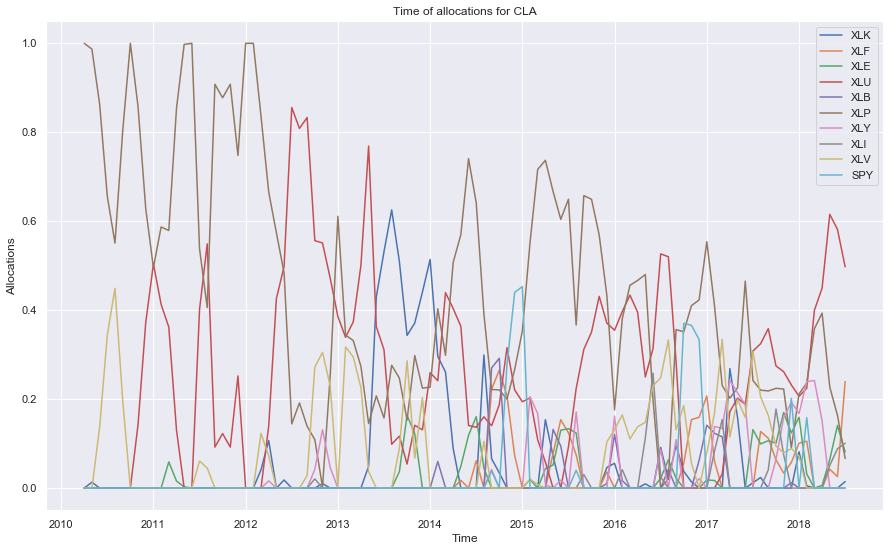

In [9]:
# CLA allocations
cla_allo.plot(figsize=(15,9))
plt.title('Time of allocations for CLA')
plt.xlabel('Time')
plt.ylabel('Allocations')

Text(0,0.5,'Allocations')

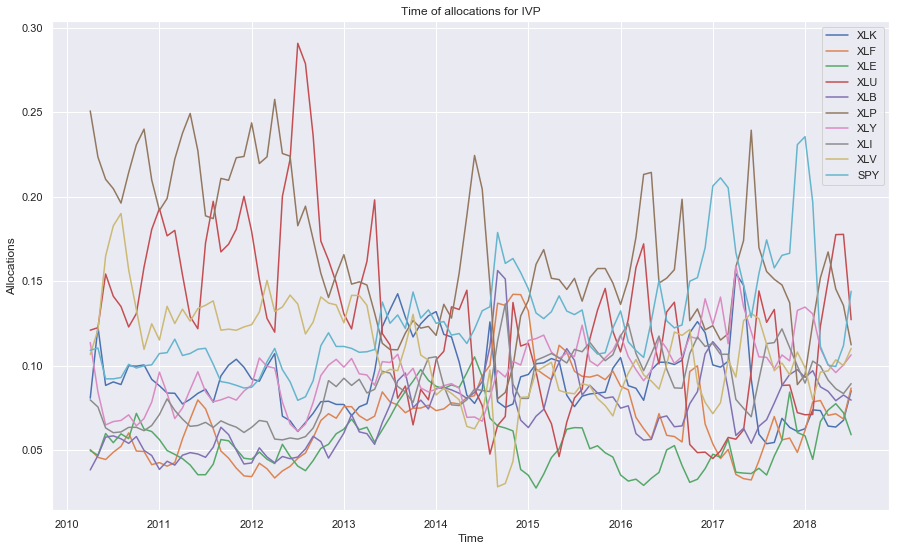

In [10]:
# IVP allocations
ivp_allo.plot(figsize=(15,9))
plt.title('Time of allocations for IVP')
plt.xlabel('Time')
plt.ylabel('Allocations')

Text(0,0.5,'Allocations')

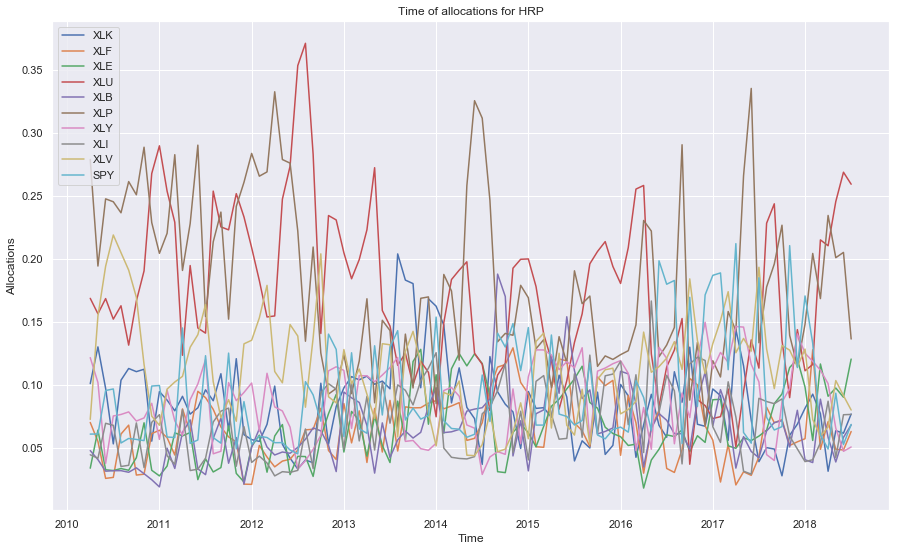

In [11]:
# HRP allocations
hrp_allo.plot(figsize=(15,9))
plt.title('Time of allocations for HRP')
plt.xlabel('Time')
plt.ylabel('Allocations')

In [12]:
# cla_allo.to_csv('cla.csv')
# ivp_allo.to_csv('ivp.csv')
# hrp_allo.to_csv('hrp.csv')

## Compute the performance statistics for each method

In [13]:
principal = 10.**6
cost_rate = 0.0005
# CLA = pd.read_csv('cla.csv',index_col=0)[:-1].T
# HRP = pd.read_csv('hrp.csv',index_col=0)[:-1].T
# IVP = pd.read_csv('ivp.csv',index_col=0)[:-1].T

CLA = cla_allo.copy(deep=True)[:-1]
IVP = ivp_allo.copy(deep=True)[:-1]
HRP = hrp_allo.copy(deep=True)[:-1]

CLA.index = CLA.index.strftime("%Y-%m-%d")
IVP.index = IVP.index.strftime("%Y-%m-%d")
HRP.index = HRP.index.strftime("%Y-%m-%d")

CLA = CLA.T
HRP = HRP.T
IVP = IVP.T

ETF = pd.read_csv('5256_project_data.csv')
mon_start = []
for e in CLA.columns:
    dft = ETF[ETF.date>=e].iloc[0,:]
    mon_start.append(dft)
Price = pd.concat(mon_start,axis=1)
CLA.columns = [e[:4]+e[5:7] for e in CLA.columns]
HRP.columns = [e[:4]+e[5:7] for e in HRP.columns]
IVP.columns = [e[:4]+e[5:7] for e in IVP.columns]
Price.columns = CLA.columns
Price = Price[1:]

## Performance Statistics

In [14]:
def back_test(df_portfolio,df_price=Price):
    # Generate backtest records of pnl, pnl from long positions and wealth
    portfolio = df_portfolio
    num_rebalances = len(portfolio.columns)-1
    portfolio_pnl = [-np.sum(np.abs(principal * portfolio.iloc[:,0] ) * cost_rate)] # Pay transaction cost when initialize the portfolio
    portfolio_pnl_long = [-principal * cost_rate]
    portfolio_wealth = [principal + portfolio_pnl[0]]
    portfolio_hit = []
    portfolio_hit_return = []
    portfolio_miss_return = []
    
    for i in range(1,num_rebalances+1): # Run each rebalance and update the recording arrays
        wealth_before_rebalance = np.sum(portfolio_wealth[i-1] * portfolio.iloc[:,i-1] * Price.iloc[:,i] / Price.iloc[:,i-1])
        transaction_cost = np.sum(wealth_before_rebalance * np.abs(portfolio.iloc[:,i] - portfolio.iloc[:,i-1]) * cost_rate)
        last_longs = portfolio.iloc[:,i-1] > 0
        period_pnl_long = (np.sum(portfolio.iloc[:,i-1][last_longs] * (Price.iloc[:,i][last_longs] / Price.iloc[:,i-1][last_longs] - 1))
                           * portfolio_wealth[i-1])
        # Cost for transactions other than open short positions will count towards pnl from long.
        now_shorts = portfolio.iloc[:,i] < 0
        transaction_cost_openshort = np.sum(np.abs(portfolio.iloc[:,i][now_shorts]-portfolio.iloc[:,i][now_shorts].apply(lambda x: min(x,0)))
                                      * Price.iloc[:,i][now_shorts]) * cost_rate
        transaction_cost_long = transaction_cost - transaction_cost_openshort
        portfolio_pnl_long.append(portfolio_pnl_long[i-1] + period_pnl_long - transaction_cost_long)
        portfolio_wealth.append(wealth_before_rebalance - transaction_cost)
        portfolio_pnl.append(portfolio_wealth[i] - principal)
        
    return pd.Series(portfolio_pnl), pd.Series(portfolio_pnl_long), pd.Series(portfolio_wealth)

### PnL

In [15]:
CLA_pnl,CLA_pnl_long,CLA_wealth = back_test(CLA)
HRP_pnl,HRP_pnl_long,HRP_wealth = back_test(HRP)
IVP_pnl,IVP_pnl_long,IVP_wealth = back_test(IVP)

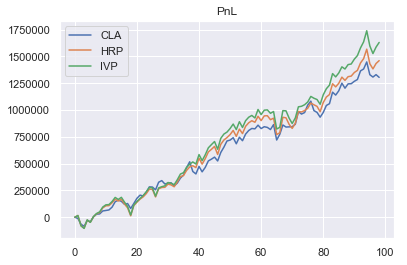

In [16]:
df_pnls = pd.concat([CLA_pnl,HRP_pnl,IVP_pnl],axis=1)
df_pnls.columns = ['CLA','HRP','IVP']
df_pnls.plot(title='PnL')

In [17]:
# Final PnL
df_pnls.iloc[-1,:]

CLA    1.305180e+06
HRP    1.461424e+06
IVP    1.631178e+06
Name: 98, dtype: float64

### PnL from long positions

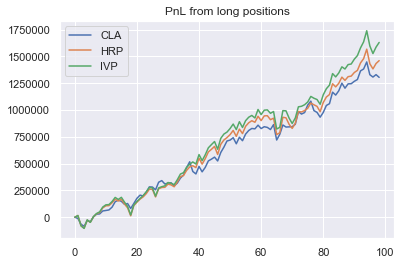

In [18]:
df_pnls_long = pd.concat([CLA_pnl_long,HRP_pnl_long,IVP_pnl_long],axis=1)
df_pnls_long.columns = ['CLA','HRP','IVP']
df_pnls_long.plot(title='PnL from long positions')

In [19]:
# Final PnL from long positions
df_pnls_long.iloc[-1]

CLA    1.305180e+06
HRP    1.461424e+06
IVP    1.631178e+06
Name: 98, dtype: float64

### Annualized rate of reutrn

In [20]:
df_wealths = pd.concat([CLA_wealth,HRP_wealth,IVP_wealth],axis=1)
df_wealths.columns = ['CLA','HRP','IVP']
num_rebalances = len(Price.columns)-1
(df_wealths.iloc[-1]/principal)**(12./num_rebalances) - 1

CLA    0.107676
HRP    0.116607
IVP    0.125763
Name: 98, dtype: float64

### Hit ratio

In [21]:
df_returns = df_wealths.diff(1)/df_wealths.shift(1)
df_hit = df_returns.copy()
df_hit[df_hit < 0] = np.nan
df_hit.count()/num_rebalances

CLA    0.663265
HRP    0.683673
IVP    0.693878
dtype: float64

### Average return from hits

In [22]:
df_hit.mean()

CLA    0.024864
HRP    0.026747
IVP    0.027784
dtype: float64

### Average return from misses

In [23]:
df_miss = df_returns.copy()
df_miss[df_miss > 0] = np.nan
df_miss.mean()

CLA   -0.022375
HRP   -0.026945
IVP   -0.028741
dtype: float64

### Returns volatility

In [24]:
ret_vol = df_returns.std()
ret_vol

CLA    0.028187
HRP    0.032516
IVP    0.033456
dtype: float64

### Sharpe ratio

In [25]:
Sharpe = ((df_wealths.iloc[-1]/principal)**(12./num_rebalances) - 1) / ret_vol
Sharpe

CLA    3.820033
HRP    3.586161
IVP    3.759099
dtype: float64

## Summary

In [26]:
summary = pd.DataFrame(columns=['CLA','HRP','IVP'])
summary.loc['PnL'] = df_pnls.iloc[-1,:]
summary.loc['PnL from long positions'] = df_pnls_long.iloc[-1]
summary.loc['Annualized rate of returns'] = (df_wealths.iloc[-1]/principal)**(12./num_rebalances) - 1
summary.loc['Hit ratio'] = df_hit.count()/num_rebalances
summary.loc['Average return from hits'] = df_hit.mean()
summary.loc['Average return from misses'] = df_miss.mean()
summary.loc['Returns volatility'] = ret_vol
summary.loc['Sharpe ratio'] = Sharpe
summary

,CLA,HRP,IVP
PnL,1.305180e+06,1.461424e+06,1.631178e+06
PnL from long positions,1.305180e+06,1.461424e+06,1.631178e+06
Annualized rate of returns,1.076763e-01,1.166071e-01,1.257630e-01
Hit ratio,6.632653e-01,6.836735e-01,6.938776e-01
Average return from hits,2.486383e-02,2.674687e-02,2.778432e-02
Average return from misses,-2.237493e-02,-2.694527e-02,-2.874053e-02
Returns volatility,2.818726e-02,3.251585e-02,3.345562e-02
Sharpe ratio,3.820033e+00,3.586161e+00,3.759099e+00


As we can see from the results, HRP and IVP both defeated CLA in terms of Sharpe Ratio or Hit Ratio. A little to our surprise, HRP did not generate the best performance as expected. We think transaction cost may play a role in this case, because we included transaction cost in the backtest step instead of in the optimization step， which may cause the real weights of assets slightly different from the designed weights after each rebalancing. When the transaction cost was set to zero, the performances of HRP and IVP were quite close.